# Multi Tool Agent

This notebook demonstrates an agent that has many tools available to answer questions. If a tool isn't found, then it is able to generate novel Cypher to answer the question.

In [1]:
import sys

DIR_SHIFT = "../../"
sys.path.append(DIR_SHIFT)

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import asyncio

from IPython.display import Image, display
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from ps_genai_agents.components.state import OutputState
from ps_genai_agents.retrievers.cypher_examples import YAMLCypherExampleRetriever
from ps_genai_agents.workflows.multi_agent import create_multi_tool_workflow

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

## Neo4j Graph

In [5]:
graph = Neo4jGraph(enhanced_schema=True)

## LLM Connections

In [6]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Additional Configurations

In [7]:
from data.bbc_recipes.queries import get_cypher_statements_dictionary, get_tool_schemas
from ps_genai_agents.components.text2cypher import get_text2cypher_schema

In [8]:
cypher_query_yaml_file_path = DIR_SHIFT + "data/bbc_recipes/queries/queries.yml"

cypher_queries_for_tools = (
    get_cypher_statements_dictionary()
)  # this is used to find Cypher queries based on a name

tool_schemas = (
    get_tool_schemas() + [get_text2cypher_schema()]
)  # these are Pydantic classes that define the available Cypher queries and their parameters

cypher_example_retriever = YAMLCypherExampleRetriever(
    cypher_query_yaml_file_path=cypher_query_yaml_file_path
)

In [9]:
print(tool_schemas)

[<class 'data.bbc_recipes.queries.schema.get_allergen_free_recipes'>, <class 'data.bbc_recipes.queries.schema.get_most_common_ingredients_an_author_uses'>, <class 'data.bbc_recipes.queries.schema.get_recipes_for_diet_restrictions'>, <class 'data.bbc_recipes.queries.schema.get_easy_recipes'>, <class 'data.bbc_recipes.queries.schema.get_mid_difficulty_recipes'>, <class 'data.bbc_recipes.queries.schema.get_difficult_recipes'>, <class 'ps_genai_agents.components.text2cypher.schema.text2cypher'>]


In [10]:
scope_description = "This application may answer questions related to cooking recipes."

In [11]:
agent = create_multi_tool_workflow(
    llm=llm,
    graph=graph,
    tool_schemas=tool_schemas,
    predefined_cypher_dict=cypher_queries_for_tools,
    scope_description=scope_description,
    cypher_example_retriever=cypher_example_retriever,
    llm_cypher_validation=False,
    attempt_cypher_execution_on_final_attempt=True,
    default_to_text2cypher=False,
)

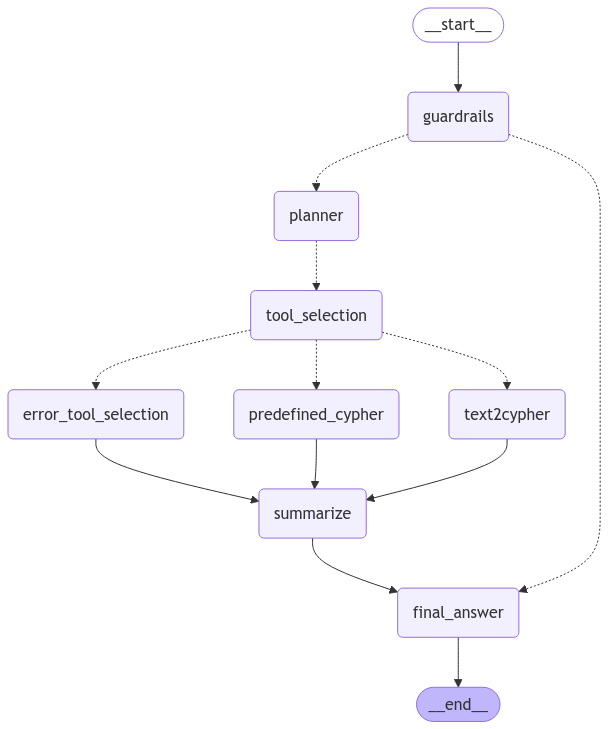

In [12]:
display(Image(agent.get_graph().draw_mermaid_png()))

## Questions

In [13]:
async def ask_question(question: str, debug: bool = False) -> OutputState:
    """wrapper to simplify asking questions in the notebook."""

    async def ask():
        response = await agent.ainvoke({"question": question}, debug=debug)
        return response

    return asyncio.run(ask())


def print_answer(response: OutputState) -> None:
    print(response.get("question"))
    print(response.get("answer"))


def print_cypher_queries(response: OutputState) -> None:
    [
        print(c.get("task", "") + "\n\n" + c.get("statement", "") + "\n\n")
        for c in response.get("cyphers", list())
    ] if response.get("cyphers") is not None else ""


def print_cypher_results(response: OutputState) -> None:
    [
        (
            print(c.get("task", "") + "\n\n"),
            [print(r) for r in c.get("records", "")],
            print("\n\n"),
        )
        for c in response.get("cyphers", list())
    ]


def print_viz_results(response: OutputState) -> None:
    [
        (
            print(v.get("task") + "\n\n" + v.get("chart_description") + "\n\n"),
            display(v.get("chart")),
        )
        for v in response.get("visualizations")
    ]

### Text2Cypher Only Question

We don't have tools that address these questions entirely, so we will need to use Text2Cypher to answer correctly. 

In [14]:
response = await agent.ainvoke(
    {
        "question": "How many authors have written a recipe?"
    },
    debug=False,
)

In [15]:
print_answer(response)

How many authors have written a recipe?
302 authors have written a recipe.


In [16]:
print_cypher_queries(response)

How many authors have written a recipe?

MATCH (a:Author)-[:WROTE]->(:Recipe)
RETURN count(DISTINCT a) AS numberOfAuthors




### Question Using Predefined Cypher Tool

We can use the `get_most_common_ingredients_an_author_uses` tool to address the following question. This reduces the number of LLM calls we have to make since we're not relying on Text2Cypher.

In [20]:
q2 = await agent.ainvoke(
    {"question": "What ingredients does emma lewis like to use most?"}, debug=True
)

[-1:checkpoint] State at the end of step -1:
{'cyphers': [], 'history': [], 'steps': [], 'tasks': [], 'visualizations': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'question': 'What ingredients does emma lewis like to use most?'}
[0:writes] Finished step 0 with writes to 1 channel:
- question -> 'What ingredients does emma lewis like to use most?'
[0:checkpoint] State at the end of step 0:
{'cyphers': [],
 'history': [],
 'question': 'What ingredients does emma lewis like to use most?',
 'steps': [],
 'tasks': [],
 'visualizations': []}
[1:tasks] Starting 1 task for step 1:
- guardrails -> {'history': [],
 'question': 'What ingredients does emma lewis like to use most?'}
[1:writes] Finished step 1 with writes to 3 channels:
- next_action -> 'planner'
- summary -> None
- steps -> ['guardrails']
[1:checkpoint] State at the end of step 1:
{'cyphers': [],
 'history': [],
 'next_action': 'planner',
 'question': 'What ingredients does emma lewis like to use most?',
 'steps': ['

In [18]:
print_answer(q2)

What ingredients does emma lewis like to use most?
I couldn't find any relevant information in the database.


In [19]:
print_cypher_queries(q2)

What are the most frequently used ingredients by Emma Lewis?


MATCH (:Author {name: $author})-[:WROTE]->(:Recipe)-[:CONTAINS_INGREDIENT]->(i:Ingredient)
RETURN i.name as name, COUNT(*) as numRecipes
ORDER BY numRecipes DESC
LIMIT 10





### Question Using Predefined Cypher and Text2Cypher

This query requires Text2Cypher to answer which vehicle has the highest number of complaints but may use the `get_all_vehicle_names` tool to answer which vehicles the user may ask about.

In [ ]:
q3 = await agent.ainvoke(
    {
        "question": "What vehicles can I ask about and which has the highest number of complaints?"
    },
    debug=False,
)

In [21]:
print_answer(q3)

What vehicles can I ask about and which has the highest number of complaints?
**Vehicles you can ask about:**

- Acura Integra
- Acura RDX
- Acura TLX
- Honda Accord
- Honda Civic
- Honda CR-V
- Honda HR-V
- Honda Odyssey
- Honda Passport
- Honda Pilot
- Honda Ridgeline
- Acura MDX

**Vehicle with the highest number of complaints:**

- Honda CR-V with 1,347 complaints


In [22]:
print_cypher_queries(q3)

What vehicles can I ask about?

MATCH (v:Vehicle)
RETURN DISTINCT v.id as name


Which vehicle has the highest number of complaints?

MATCH (v:Vehicle)-[:HAS_VERBATIM]->(verbatim:Verbatim)
WITH v, COUNT(verbatim) AS totalComplaints
RETURN v.id AS vehicle, totalComplaints
ORDER BY totalComplaints DESC
LIMIT 1


